<div>
    <font face="Times New Roman" style="text-align: center;">
        <h1>Beyond Reviews</h1>
        <h2>Validating online consumer reviews using unsupervised machine learning methods.</h2>
        <p><strong>Date:</strong> June 15, 2024</p>
        <p><strong>Student:</strong> Maurits Christiaan Graaf</p>
        <p><strong>Studentnumber:</strong> 660509</p>
        <p><strong>Supervisor:</strong> Dr. D.J. (David) Kusterer</p>
        <p><strong>Second Reader:</strong> Dr. M. (Maciej) Szymanowski</p>
        <p><strong>Department:</strong> Marketing</p>
        <p><strong>University:</strong> Rotterdam School of Management</p>
    </font>
</div>

# Importing Packages
This codeblock imports the necessary packages.

In [1]:
##### ------ Importing Packages ------ #####
#General packages
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import fraud_eagle as feagle
import matplotlib.pyplot as plt
from UGFraud.Detector.SpEagle import *
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Set style for seaborn
sns.set(style="whitegrid")

# Dataset

Import the dataset created and prepared in 'Fake reviews notebook ~ data preparation'

In [3]:
# Read from pickle (pkl)
concatenated_df = pd.read_pickle('concatenated_df.pkl')

#Check whether import functioned correctly
print(concatenated_df.shape)

print(concatenated_df.columns)

(149880, 47)
Index(['Review_Rating', 'Review_Title', 'Review_Text', 'Review_Images',
       'Product_ASIN', 'Parent_Product_ASIN', 'User_ID', 'Review_Timestamp',
       'Helpful_Votes', 'Verified_Purchase', 'Main_Category', 'Product_Title',
       'Product_Average_Rating', 'Count_product_ratings', 'Product_Features',
       'Product_Description', 'Product_Price', 'Product_Images',
       'Product_Videos', 'Product_Store', 'Product_Categories',
       'Product_Details', 'Products_Bought_Together', 'Product_Subtitle',
       'Product_Author', 'overall_category', 'Review_Title_Length',
       'Review_Text_Length', 'Rating_Difference', 'Review_Rank',
       'Extreme_Rating', 'Average_Text_Length', 'Text_Length_Difference',
       'Review_Count', 'Singular_Review', 'Review_Words', 'Review_Word_Count',
       'Fully_Capitalized_Words_Count', 'Fully_Capitalized_Words_Proportion',
       'Capital_Letters_Excluding_Start_Count',
       'Capital_Letters_Excluding_Start_Percentage',
       'First

# Fitting the FraudEagle

#### Creating the FraudEagle network graph

In [4]:
# Create a graph with a parameter `epsilon`.
epsilon = 0.25
graph = feagle.ReviewGraph(epsilon)

# Extract relevant columns
review_data = concatenated_df[['User_ID', 'Product_ASIN', 'Review_Rating']]

In [5]:
# Normalize the ratings
max_rating = review_data['Review_Rating'].max()
min_rating = review_data['Review_Rating'].min()

review_data['Normalized_Rating'] = (review_data['Review_Rating'] - min_rating) / (max_rating - min_rating)

C:\Users\Maurits\AppData\Local\Temp\ipykernel_16992\1171559145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Normalized_Rating'] = (review_data['Review_Rating'] - min_rating) / (max_rating - min_rating)


In [6]:
# Add reviewers and products to the graph
reviewers = {}
products = {}

for index, row in review_data.iterrows():
    reviewer_id = row['User_ID']
    product_id = row['Product_ASIN']
    rating = row['Normalized_Rating']
    
    # Add reviewer
    if reviewer_id not in reviewers:
        reviewers[reviewer_id] = graph.new_reviewer(reviewer_id)
    
    # Add product
    if product_id not in products:
        products[product_id] = graph.new_product(product_id)
    
    # Add review
    graph.add_review(reviewers[reviewer_id], products[product_id], rating)

In [7]:
# Run analysis
print("Start iterations.")
max_iteration = 10000
for i in range(max_iteration):
    diff = graph.update()
    print(f"Iteration {i + 1} ends. (diff={diff})")
    if diff < 10**-5:
        break

# Retrieve results
reviewer_scores = {r.name: r.anomalous_score for r in graph.reviewers}
product_summaries = {p.name: p.summary for p in graph.products}

Start iterations.
Iteration 1 ends. (diff=0.16666666666666952)
Iteration 2 ends. (diff=0.06755942932584907)
Iteration 3 ends. (diff=0.0017725396917553926)
Iteration 4 ends. (diff=8.335459555142144e-06)


#### Displaying the FraudEagle review graphs

A simplified subset of the entire graph is displayed in a review graph

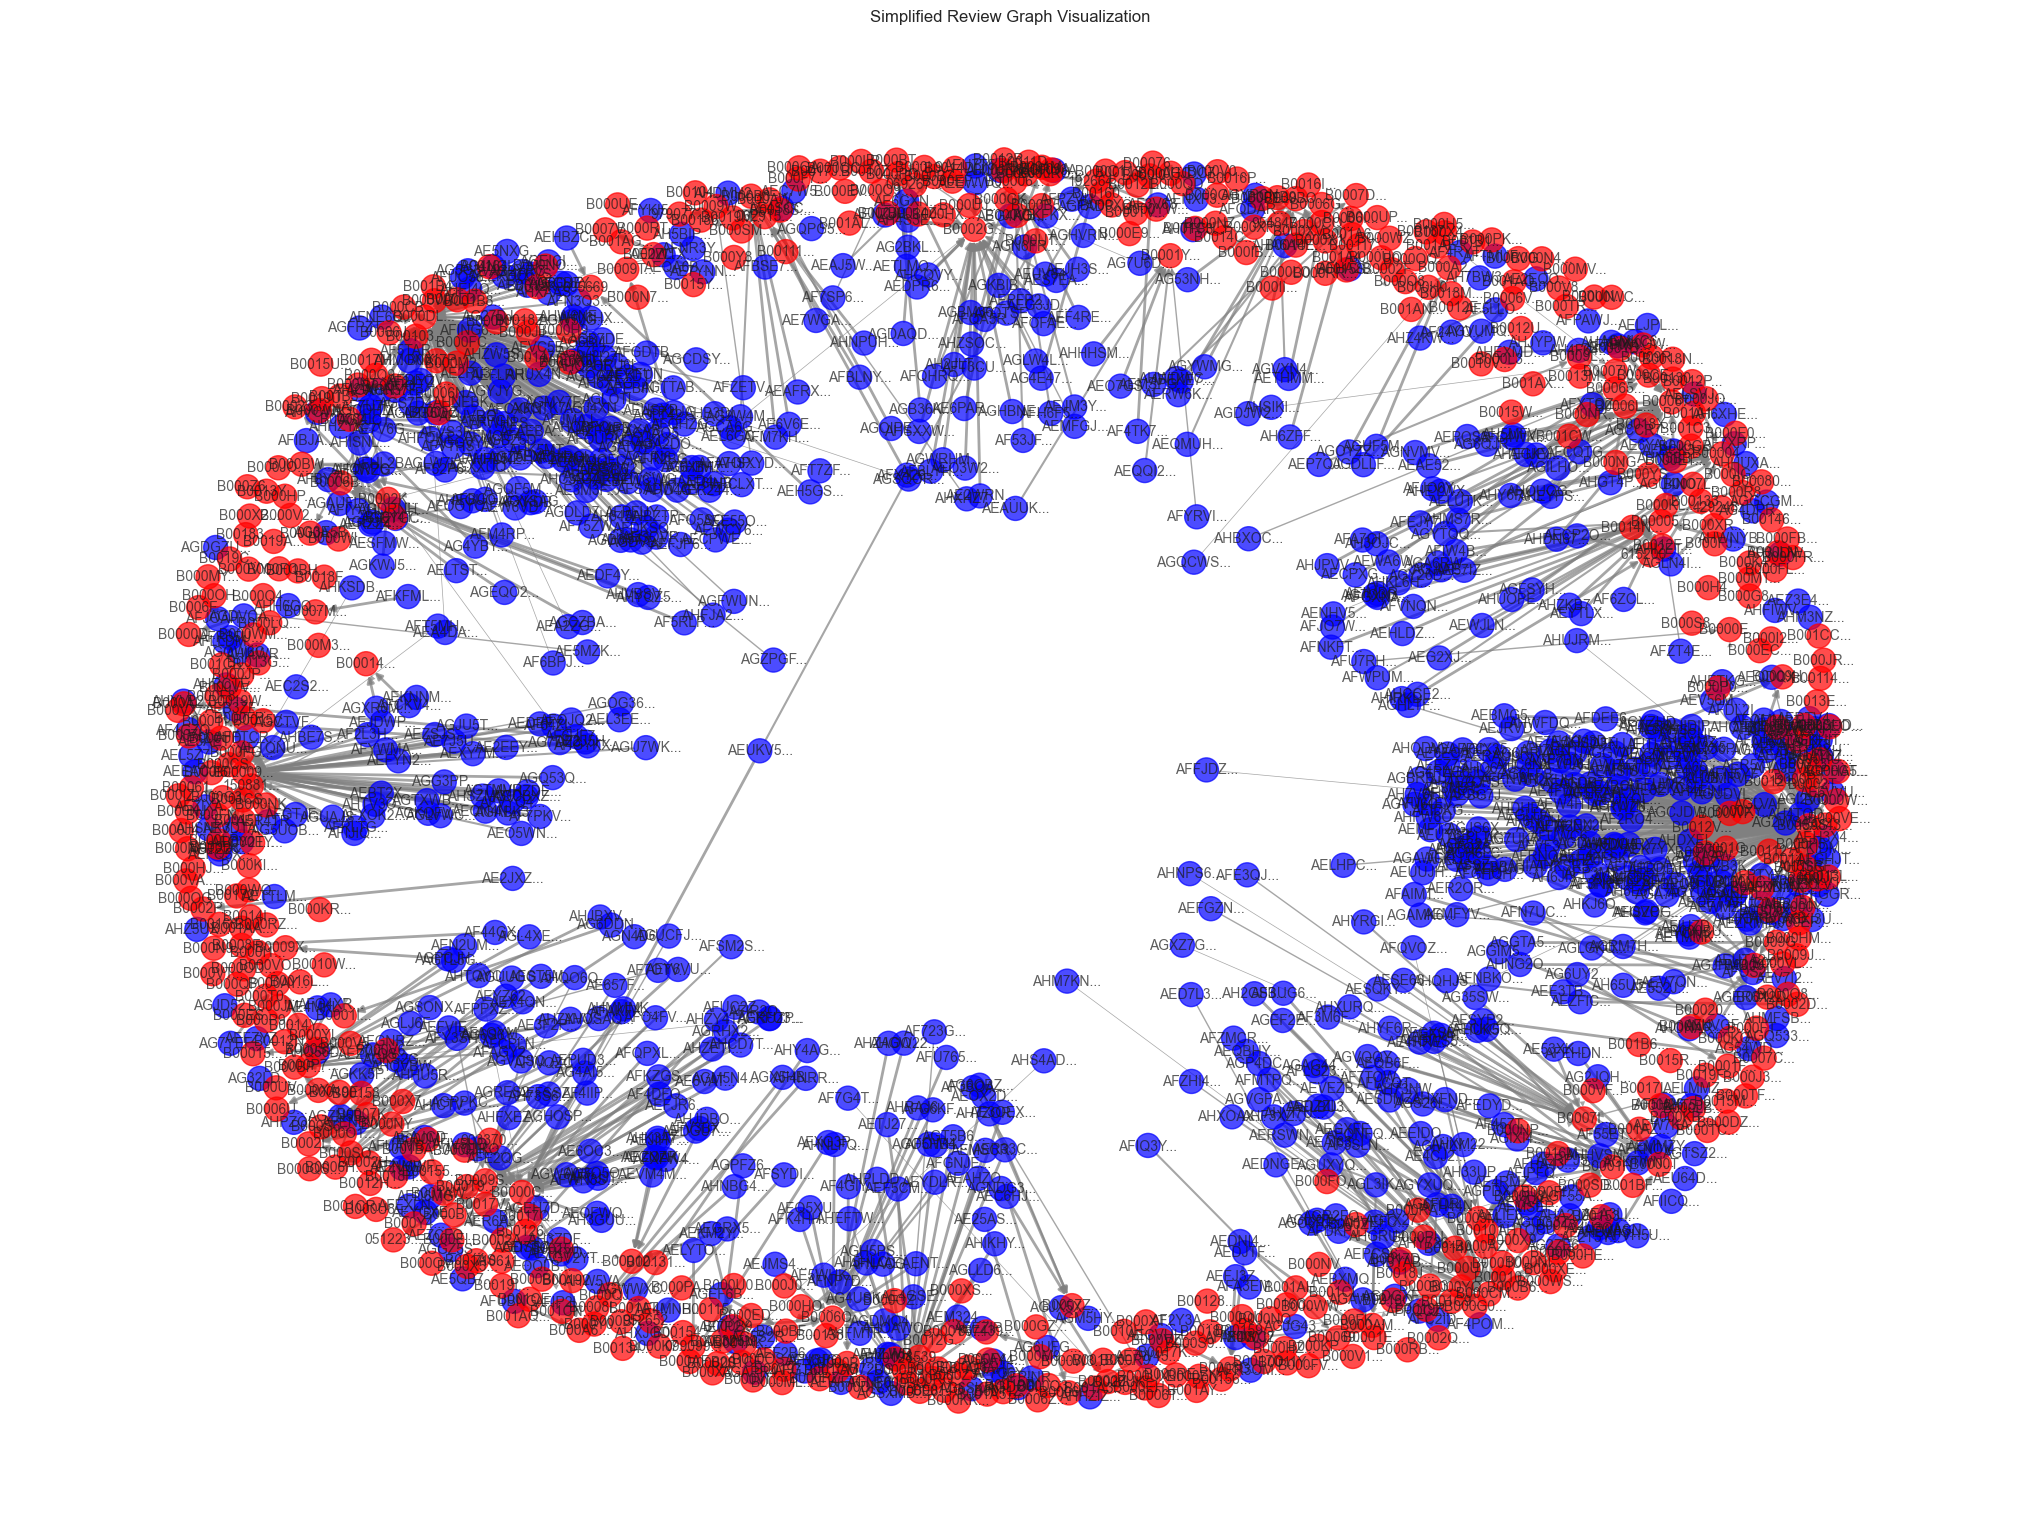

In [8]:
# Simplified graph visualization
# Select a subset of the graph for visualization
subset_reviewers = list(reviewer_scores.keys())[:1000]
subset_products = list(product_summaries.keys())[:1000]

# Abbreviate IDs for visualization
abbreviate = lambda x: x[:6] + '...' if len(x) > 6 else x
abbreviated_reviewers = {reviewer: abbreviate(reviewer) for reviewer in subset_reviewers}
abbreviated_products = {product: abbreviate(product) for product in subset_products}

# Visualize the subset of the graph using networkx
G = nx.DiGraph()

# Add nodes
for reviewer in subset_reviewers:
    G.add_node(abbreviated_reviewers[reviewer], bipartite=0, color='blue')
for product in subset_products:
    G.add_node(abbreviated_products[product], bipartite=1, color='red')

# Add edges
for index, row in review_data.iterrows():
    if row['User_ID'] in subset_reviewers and row['Product_ASIN'] in subset_products:
        G.add_edge(abbreviated_reviewers[row['User_ID']], abbreviated_products[row['Product_ASIN']], weight=row['Normalized_Rating'])

# Draw the simplified graph
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, k=0.1)  # k controls the distance between nodes
colors = ['blue' if data['bipartite'] == 0 else 'red' for _, data in G.nodes(data=True)]
weights = [G[u][v]['weight'] * 2 for u, v in G.edges]  # Smaller weight scaling for clarity

nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', width=weights, alpha=0.7, font_size=10)
plt.title("Simplified Review Graph Visualization")
plt.show()

#### Displaying the graph for the most reviewed product

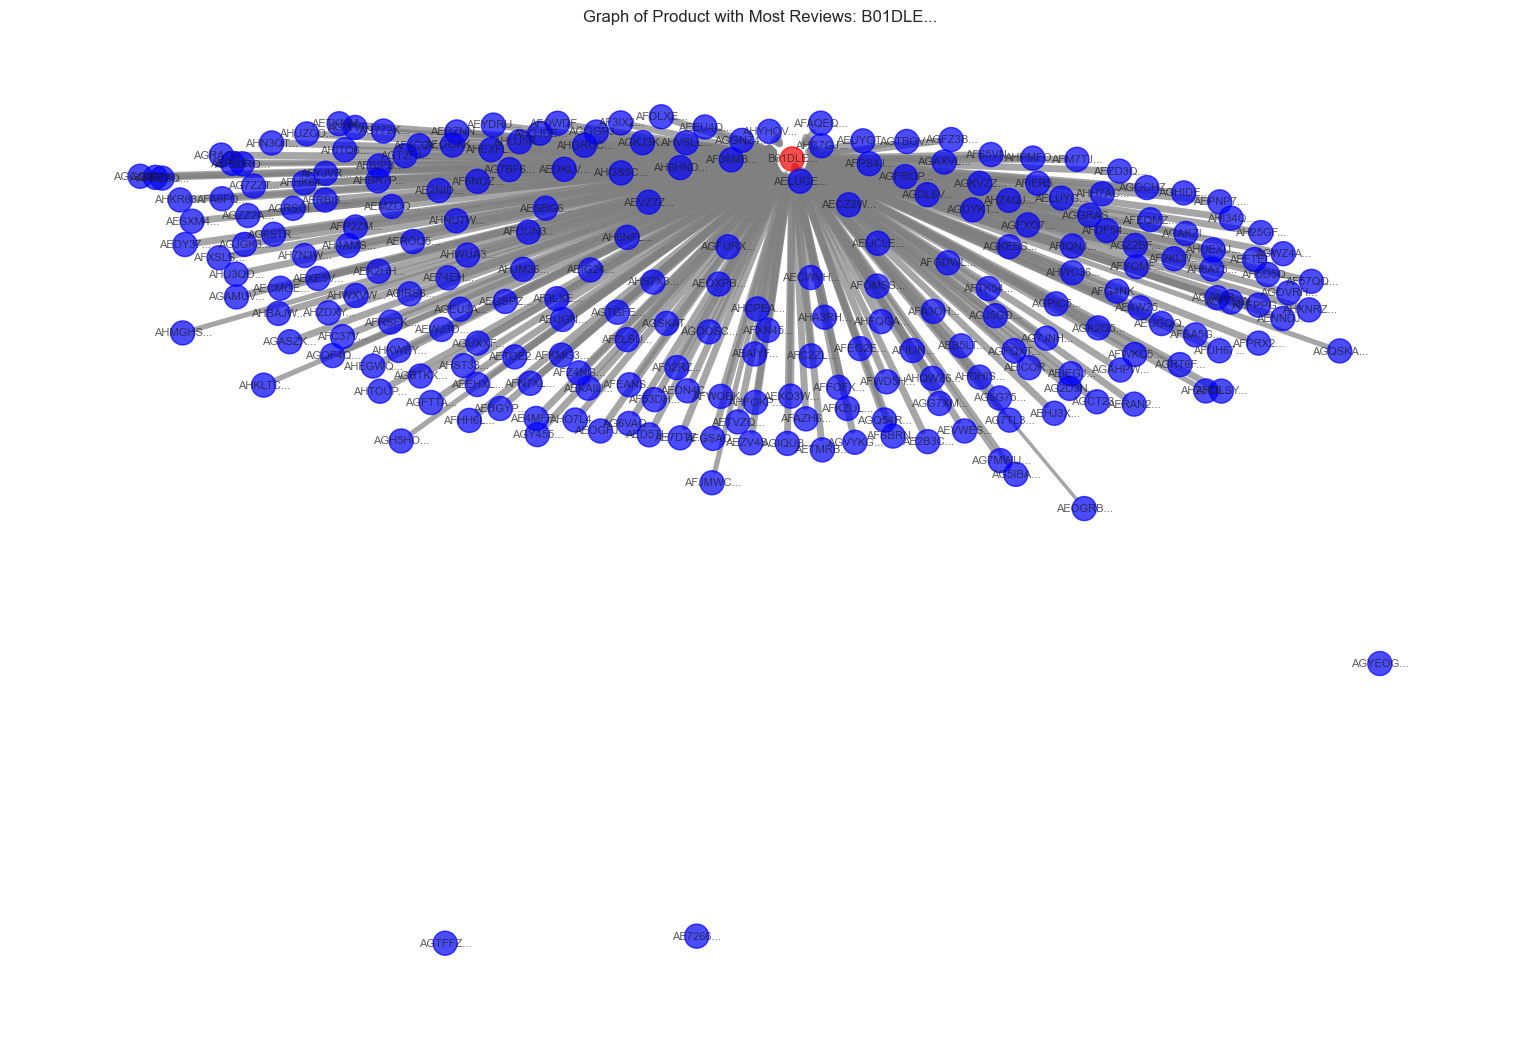

Product with Most Reviews: B01DLEL4EM
Number of Reviews: 236


In [9]:
# Identify the product with the most reviews
product_review_counts = review_data['Product_ASIN'].value_counts()
most_reviewed_product = product_review_counts.idxmax()

# Filter data for the most reviewed product
most_reviewed_data = review_data[review_data['Product_ASIN'] == most_reviewed_product]

# Abbreviate IDs for visualization
abbreviate = lambda x: x[:6] + '...' if len(x) > 6 else x
abbreviated_most_reviewed_product = abbreviate(most_reviewed_product)
abbreviated_reviewers = {row['User_ID']: abbreviate(row['User_ID']) for index, row in most_reviewed_data.iterrows()}

# Create subgraph for the most reviewed product
G_most_reviewed = nx.DiGraph()

# Add the most reviewed product node
G_most_reviewed.add_node(abbreviated_most_reviewed_product, bipartite=1, color='red')

# Add reviewer nodes and edges
for index, row in most_reviewed_data.iterrows():
    reviewer_id = row['User_ID']
    G_most_reviewed.add_node(abbreviated_reviewers[reviewer_id], bipartite=0, color='blue')
    G_most_reviewed.add_edge(abbreviated_reviewers[reviewer_id], abbreviated_most_reviewed_product, weight=row['Normalized_Rating'])

# Draw the subgraph for the most reviewed product
plt.figure(figsize=(15, 10))  # Widen the graph
pos = nx.spring_layout(G_most_reviewed, k=0.3)  # Adjust layout spread
colors = ['red' if data['bipartite'] == 1 else 'blue' for _, data in G_most_reviewed.nodes(data=True)]
weights = [G_most_reviewed[u][v]['weight'] * 5 for u, v in G_most_reviewed.edges]  # Adjust width scaling

nx.draw(G_most_reviewed, pos, with_labels=True, node_color=colors, edge_color='gray', width=weights, alpha=0.7, font_size=8)
plt.title(f"Graph of Product with Most Reviews: {abbreviated_most_reviewed_product}")
plt.show()

# Summary of the most reviewed product
print(f"Product with Most Reviews: {most_reviewed_product}")
print(f"Number of Reviews: {product_review_counts.max()}")

C:\Users\Maurits\AppData\Local\Temp\ipykernel_16992\2622256430.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[abbreviate(name) for name in top_reviewers_names], y=top_reviewers_scores, palette="Blues_d")


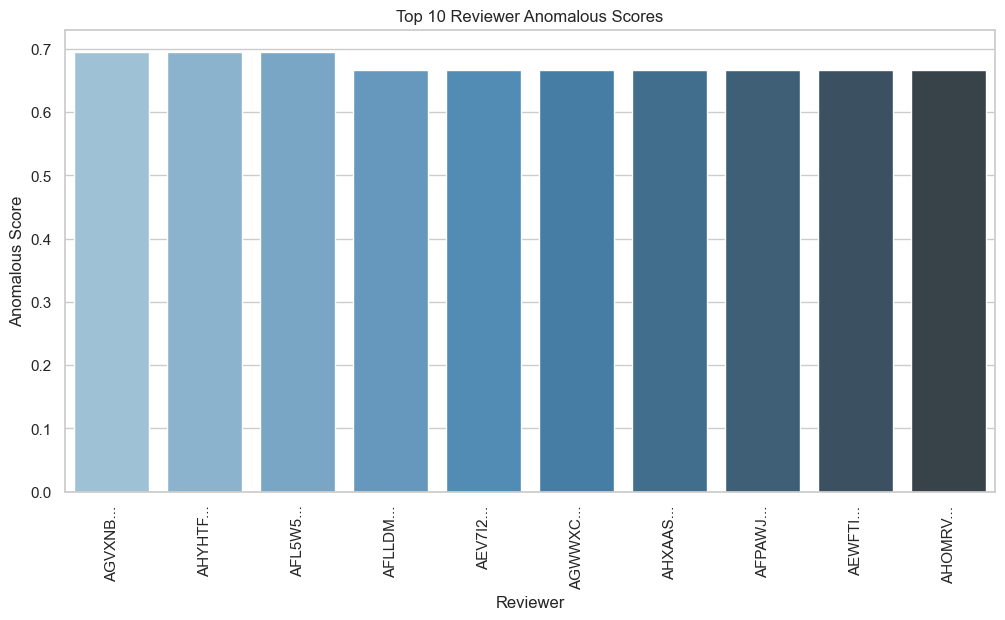

In [10]:
# Plot top 10 reviewer anomalous scores
top_reviewers = sorted(reviewer_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_reviewers_names, top_reviewers_scores = zip(*top_reviewers)

plt.figure(figsize=(12, 6))
sns.barplot(x=[abbreviate(name) for name in top_reviewers_names], y=top_reviewers_scores, palette="Blues_d")
plt.xlabel('Reviewer')
plt.ylabel('Anomalous Score')
plt.title('Top 10 Reviewer Anomalous Scores')
plt.xticks(rotation=90)
plt.show()

C:\Users\Maurits\AppData\Local\Temp\ipykernel_16992\1194862920.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[abbreviate(name) for name in top_products_names], y=top_products_summaries, palette="Reds_d")


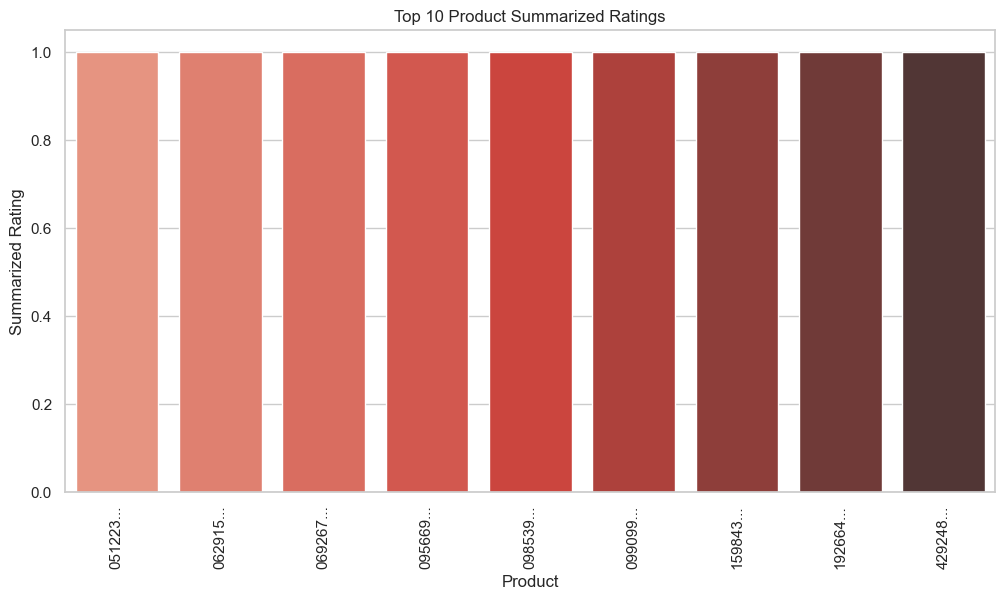

In [11]:
# Plot top 10 product summarized ratings
top_products = sorted(product_summaries.items(), key=lambda x: x[1], reverse=True)[:10]
top_products_names, top_products_summaries = zip(*top_products)

plt.figure(figsize=(12, 6))
sns.barplot(x=[abbreviate(name) for name in top_products_names], y=top_products_summaries, palette="Reds_d")
plt.xlabel('Product')
plt.ylabel('Summarized Rating')
plt.title('Top 10 Product Summarized Ratings')
plt.xticks(rotation=90)
plt.show()